# Importación de librerías

In [1]:
%matplotlib inline
!pip install scikit-learn
!pip install seaborn
!pip install geopandas matplotlib

import os
import csv
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from glob import glob
import geopandas as gpd

from scipy.spatial import distance_matrix
from sklearn.preprocessing import MinMaxScaler

# Para no mostrar 'Future Warnings' producto de que algunos paquetes aún
# trabajan con versiones no actualizadas de otros paquetes
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Función para transformar los txt de resultados a csv

In [6]:
def txt_to_csv(input_file, output_file):
    with open(input_file, 'r') as txt_file:
        # Lee el archivo de texto línea por línea
        lines = txt_file.readlines()

    with open(output_file, 'w', newline='') as csv_file:
        writer = csv.writer(csv_file)

        for line in lines:
            # Divide cada línea en valores separados por comas
            values = line.strip().split(',')
            # Escribe los valores en el archivo CSV
            writer.writerow(values)

def txt_files_to_csv_folder(input_folder, output_folder):
    # Comprueba si el directorio de salida existe, si no, créalo
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Obtiene la lista de archivos .txt en el directorio de entrada
    txt_files = [file for file in os.listdir(input_folder) if file.endswith('.txt')]

    # Itera sobre cada archivo .txt y conviértelo a CSV
    for txt_file in txt_files:
        input_file_path = os.path.join(input_folder, txt_file)
        output_file_path = os.path.join(output_folder, txt_file.replace('.txt', '.csv'))
        txt_to_csv(input_file_path, output_file_path)

In [61]:
#Con mi organizacion de directorios sería
txt_files_to_csv_folder('.\Resultados', '.\Resultados_csv')

# Creación de dataframes

Con estas funciones, se genera una lista de dataframes con todos los csv del directorio que introduzcamos(En mi caso, sería el directorio '.\Resultados_csv'), además de esto se le añade al título de cada columna el nombre del fichero, permitiendonos filtrar fácilmente.

In [9]:
def csv_to_dataframe(csv_file):
    return pd.read_csv(csv_file)

def csv_files_to_dataframe_folder(input_folder):
    # Obtiene la lista de archivos CSV en el directorio de entrada
    csv_files = [file for file in os.listdir(input_folder) if file.endswith('.csv')]
    dataframes = []
    
    for csv_file in csv_files:
        csv_file_path = os.path.join(input_folder, csv_file)
        df = csv_to_dataframe(csv_file_path)
        # Renombra las columnas para incluir el nombre del archivo al final del nombre de la columna
        df = df.rename(columns=lambda x: f"{x}_{os.path.splitext(csv_file)[0]}")
        # Agrega el DataFrame a la lista
        dataframes.append(df)
    
    return dataframes

De esta manera, ya tenemos una lista con todos los dataframes del directorio.

In [10]:
input_folder = '.\Resultados_csv'
dataframes = csv_files_to_dataframe_folder(input_folder)
print(len(dataframes))
dataframes[1]

9


,num_steps_Basic_openMP_8,Estimaci¾n pi_Basic_openMP_8,Diferencia pi_Basic_openMP_8,Tiempo de ejecuci¾n_Basic_openMP_8
0,10000000,3.141593,-1.000000e-07,0.035672
1,20000000,3.141593,-1.000000e-07,0.076739
2,40000000,3.141593,-1.000000e-07,0.107972
3,80000000,3.141593,-1.000000e-07,0.220381
4,160000000,3.141593,-1.000000e-07,0.414010
5,320000000,3.141593,-1.000000e-07,0.835199
6,640000000,3.141593,-1.000000e-07,1.686308
7,1280000000,3.141593,-1.000000e-07,3.332096
8,2560000000,3.141593,-1.000000e-07,6.654760
9,5120000000,3.141593,-1.000000e-07,13.376870


Antes de generar las listas de dataframes, vamos a cambiar todos los nombres personalizados de num_steps_tipo a num_steps, para poder combinar los dataframes por dicha columna

In [14]:
def rename_num_steps_columns(dataframes):
    
    for i, df in enumerate(dataframes):
        # Renombra las columnas que contienen 'num_steps_'
        df.columns = ['num_steps' if 'num_steps_' in col else col for col in df.columns]
        dataframes[i] = df  # Actualiza el DataFrame en la lista
    return dataframes

In [20]:
dataframes = rename_num_steps_columns(dataframes)
dataframes[0]

,num_steps,Estimación pi_Basic_MPI_cluster_8,Diferencia pi_Basic_MPI_cluster_8,Tiempo de ejecución_Basic_MPI_cluster_8
0,10000000,3.141593,-1.000000e-07,0.035863
1,20000000,3.141593,-1.000000e-07,0.022100
2,40000000,3.141593,-1.000000e-07,0.039896
3,80000000,3.141593,-1.000000e-07,0.045129
4,160000000,3.141593,-1.000000e-07,0.087928
5,320000000,3.141593,-1.000000e-07,0.175930
6,640000000,3.141593,-1.000000e-07,0.353394
7,1280000000,3.141593,-1.000000e-07,0.705969
8,2560000000,3.141593,-1.000000e-07,1.408125
9,5120000000,3.141593,-1.000000e-07,2.815213


Hacemos una lista de dataframes con cada tipo a analizar

In [23]:
BasicDataframes = []
MontecarloDataframes = []
OpenMPDataframes = []
MPIDataframes = []
GeneralDataframes = dataframes

for i in dataframes:
    if 'Basic' in i.columns[1]:
        BasicDataframes.append(i)
    if 'Montecarlo' in i.columns[1]:
        MontecarloDataframes.append(i)
    if 'open' in i.columns[1].lower():
        OpenMPDataframes.append(i)
    if 'mpi' in i.columns[1].lower():
        MPIDataframes.append(i)
    #Compruebo en la columna 1 ya que la 0 es un nombre generalizado para combinar los dataframes
print(len(GeneralDataframes),len(BasicDataframes), len(MontecarloDataframes),len(OpenMPDataframes), len(MPIDataframes))

9 5 4 3 3


In [24]:
MPIDataframes[0]

,num_steps,Estimación pi_Basic_MPI_cluster_8,Diferencia pi_Basic_MPI_cluster_8,Tiempo de ejecución_Basic_MPI_cluster_8
0,10000000,3.141593,-1.000000e-07,0.035863
1,20000000,3.141593,-1.000000e-07,0.022100
2,40000000,3.141593,-1.000000e-07,0.039896
3,80000000,3.141593,-1.000000e-07,0.045129
4,160000000,3.141593,-1.000000e-07,0.087928
5,320000000,3.141593,-1.000000e-07,0.175930
6,640000000,3.141593,-1.000000e-07,0.353394
7,1280000000,3.141593,-1.000000e-07,0.705969
8,2560000000,3.141593,-1.000000e-07,1.408125
9,5120000000,3.141593,-1.000000e-07,2.815213


Concatenamos cada listas de dataframes(Es importante que todos los dataframes tengan una columna con un mismo nombre y valores)

In [26]:
def combina_dataframes(dataframes):
    combined_df = dataframes[0]
    for df in dataframes[1:]:
        combined_df = pd.merge(combined_df, df, on='num_steps', how='outer')
    return combined_df

In [28]:
BasicDataframes_combinado = combina_dataframes(BasicDataframes)
MontecarloDataframes_combinado = combina_dataframes(MontecarloDataframes)
OpenMPDataframes_combinado = combina_dataframes(OpenMPDataframes)
MPIDataframes_combinado = combina_dataframes(MPIDataframes)
GeneralDataframes_combinado = combina_dataframes(GeneralDataframes)

# Análisis de dataframes(Aceleración)

El primero de los análisis de rendimiento, será la aceleración, para ello crearemos una función en la cual, introduciremos los métodos a analizar y el tipo de función que analizaremos(Basic/Montecarlo). Además añadiré una función que devuelva la aceleración respecto al método base según el tipo.

In [62]:
def aceleracion(m1,m2,tipo):
    if tipo == "Montecarlo":
        #Buscamos las columnas que vamos a comparar dentro del dataframe haciendo que contengan la cadena Tiempo y
        #el método m1 o m2
        column1 = [col for col in MontecarloDataframes_combinado.columns if m1 in col and 'Tiempo' in col]
        column2 = [col for col in MontecarloDataframes_combinado.columns if m2 in col and 'Tiempo' in col]
        return (MontecarloDataframes_combinado[column1[0]] / MontecarloDataframes_combinado[column2[0]]).mean()
    else:
        column1 = [col for col in BasicDataframes_combinado.columns if m1 in col and 'Tiempo' in col]
        column2 = [col for col in BasicDataframes_combinado.columns if m2 in col and 'Tiempo' in col]
        return (BasicDataframes_combinado[column1[0]] / BasicDataframes_combinado[column2[0]]).mean()

def aceleracion_base(m1,tipo):
    return aceleracion('sin_optimizar',m1,tipo)

Los valores que pueden tomar m1 y m2 para calcular la aceleración dependerán de los métodos que hayas probado para generar resultados.<br>
Para Montecarlo, en mi caso, pueden ser: sin_optimizar,optimizado,openMP_16 y MPI_cluster_8.<br>
Para Basic, pueden ser: sin_optimizar,optimizado,openMP_8, MPI_cluster_8 y OpenMP_y_MPI_8_4<br>
**¡Importante! Si la aceleración es menor que 1, para saber la aceleración real, deberá cambiar el orden de los métodos a comparar, la función está heca para poner en primer lugar la más lenta**

In [63]:
#Ejemplo de cómo se usaría la función de aceleración
aceleracion('sin_optimizar','optimizado','Montecarlo')

1.1218707171940552

In [64]:
#Ejemplo de cómo se usaría la función de aceleración respecto al método sin optimizar
aceleracion_base('optimizado','Montecarlo')

1.1218707171940552

# Análisis de dataframes(Diferencia en la estimación de pi)

Tras haber visto cómo podemos calcular la aceleración entre distintos métodos, según su tipo(Basic/Montecarlo);
ahora añadiré una función, para calcular el error medio en el cálculo de la diferencia entre la estimación de pi y su valor real, para Montecarlo.

In [66]:
def error_promedio_estimacion_pi(m):
    #Primero buscamos las columnas que vamos a comparar dentro del dataframe haciendo que contengan la cadena Tiempo y
    #el método m1 o m2
    column = [col for col in MontecarloDataframes_combinado.columns if m in col and 'Diferencia' in col]
    return (MontecarloDataframes_combinado[column[0]]).abs().mean()

In [69]:
#Ejemplo de cómo se usaría la función, en m podremos poner los valores que designamos para Montecarlo en la sección anterior
error_promedio_estimacion_pi('MPI_cluster_8')

8.057999999999999e-05

# Análisis de dataframes(Generar gráficas)

Una manera interesante de analizar los resultados, es hacerlo de forma visual mediante gráficas, para ello, crearemos una función general que nos muestre una gráfica, en escala logarítmica, para apreciar mejor los valores respecto al num_steps, ya que este aumenta duplicándose por iteración. Esta gráfica mostrará los tiempos de ejecución de los distintos métodos.

In [84]:
def genera_grafica(df, y_columns,repo_path=None,filename=None): 
    # Crear el gráfico
    plt.figure(figsize=(10, 6))
    
    # Iterar sobre las columnas del eje y y representarlas
    for column in y_columns:
        plt.plot(df['num_steps'], df[column], label=column)
        plt.scatter(df['num_steps'], df[column])

    # Establecer la escala logarítmica en el eje x
    plt.xscale('log')

    # Añadir etiquetas y leyenda
    plt.xlabel('num_steps')
    plt.ylabel('Tiempo de ejecución')
    plt.title('Gráfico Tiempo ejecución/num_steps')
    plt.legend()

    # Guardar el gráfico como un archivo PNG si se proporciona un nombre de archivo
    if filename and repo_path:
        filepath = os.path.join(repo_path, filename)
        plt.savefig(filepath)
    # Mostrar el gráfico
    plt.show()

Primero crearé una función para extraer todas las columnas de tiempo de ejecución de un dataframe.

In [85]:
def time_columns(df):
    columnas = [col for col in df.columns if 'Tiempo' in col]
    return columnas

Para usar la función genera_grafica, damos como datos de entrada, primero el dataframe, luego una lista de columnas de tiempos de ejecución(podemos usar la función auxiliar anterior) y si queremos guardar una imagen de la gráfica en un repositorio en particular, hay que añadir el path del repositorio de salida y el nombre de la imagen.

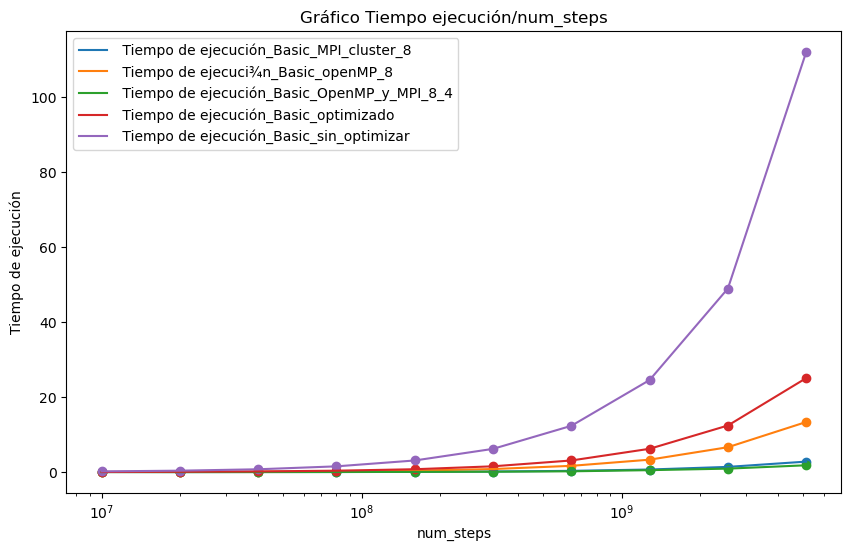

In [87]:
#Si solo damos el dataframe y las columnas nos haría el print sin guardar la imagen
genera_grafica(BasicDataframes_combinado,time_columns(BasicDataframes_combinado))
#Para guardar la imagen de la gráfica habría que añadir el path y nombre
#genera_grafica(BasicDataframes_combinado,time_columns(BasicDataframes_combinado),ruta_directorio_salida,nombre_imagen)